<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Flag_of_the_United_States.svg/320px-Flag_of_the_United_States.svg.png">
</td>


# Analyse des sources de l'édition étatsunienne du *Huff Post* (2011-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre <i>notebook</i> et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 25
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "États-Unis"
huff = huff[huff.pays == edition]
huff.shape

(550955, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

The Huffington Post     549630
EW.com                  439   
Just Jared              139   
TMZ                     113   
POPSUGAR Celebrity      103   
Vulture                 95    
Celebuzz                91    
Gossip Cop              57    
Us Weekly               27    
TVGuide.com             25    
BuzzFeed                13    
Newser                  11    
                        ..    
Consequence of Sound    1     
EverydayHealth.com      1     
Glamour                 1     
Chicago magazine        1     
ESPN.com                1     
Salon                   1     
AfterEllen              1     
Medium                  1     
Mashable                1     
Dazed                   1     
Vanity Fair             1     
The Boot                1     
Name: meta, Length: 102, dtype: int64

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

The Huffington Post    549630
AOL.ca                 2     
L'Huffington Post      2     
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(549634, 13)

In [7]:
len(huff) - len(huff[metaHP])

1321

Le calcul ci-haut nous indique qu'on a **945 articles** qu'on peut d'ores et déjà ranger dans la catégorie des articles qui ne sont *pas* rédigés par l'équipe du *HuffPost*.
<hr>
Examinons cependant de plus près notre sous-ensemble d'articles dont la balise `meta` prétend qu'ils sont issus du *HuffPost* en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

?                                                                                                                                                                                                      90201
reuters                                                                                                                                                                                                22934
The Huffington Post                                                                                                                                                                                    6467 
Cavan Sieczkowski The Huffington Post                                                                                                                                                                  2511 
Ellie Krupnick The Huffington Post                                                                                                                                                  

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;»).<br>
Ils seront placés dans le sous-ensemble `inconnus`.<br>
Ils représentent un peu plus de **16%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus = huff[metaHP].byline == "?"
HP_inconnu = huff[metaHP][inconnus].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(90201, 16.371754499006272)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(243329, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(The Huffington Post                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               6467
 Cavan Sieczkowski The Huffington Post                                                                                                                                                                                                                                                                                                          

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **243&nbsp;329 articles** signés par **6&nbsp;517 signataires différents**.<br>
Cela représente un peu **moins de la moitié** de l'ensemble des articles publiés par l'édition américaine du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(243329, 44.164949950540425)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(306305, 13)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count() 

(?                                                                                                                                                                                                          90201
 reuters                                                                                                                                                                                                    22934
 Jason Linkins                                           Editor, Eat the Press                                                                                                                              1901 
 The New York Times                                                                                                                                                                                         1823 
 OWN                                                                                                                                                            

Des quelque 59&nbsp;359 signataires ci-dessus (!), par contre, on trouve plusieurs «&nbsp;employés fantôme&nbsp;».

Lorsqu'un nom d'auteur apparaît seul, il semble que cet auteur ne fasse pas partie de l'équipe du *HuffPost* et que son article est une reproduction d'une source extérieure. C'est le cas, par exemple, de [Aaron Sankin](https://www.revealnews.org/author/aaron-sankin/).

Lorsqu'un nom d'auteur est précédé de *«&nbsp;By &nbsp;»*, il semble que cet auteur fasse partie de l'équipe du *HuffPost*. C'est le cas de [Carla Herreria](https://www.huffingtonpost.com/author/carla-herreria), par exemple.

Nous allons donc isoler ces auteurs dont le *byline* commence par *«&nbsp;By &nbsp;»*, sauf ceux qui contiennent une virgule ou un deux-points ou le mot *«&nbsp;for&nbsp;»*, car il s'agit d'articles écrits dans d'autres médias. On va aussi exclure les noms de différentes agences ou publications, comme The Associated Press ou *Golfweek*.

In [15]:
by = huff[metaHP][NONsigneHP].byline.str.startswith("By ")
virgule = ~huff[metaHP][NONsigneHP][by].byline.str.contains(",|:| for | via |.com|AP| Forbes|TIME|iVillage|Mosaic|CNN|NBC| Onion|LuxEcoLiving| National Geographic|Science of Us|Evening Post|Speakeasy|Associated|ASSOCIATED|Bloomberg|olfwee[e,k]|MIRRORS|ARTINFO|Artinfo|Football Post| Travel|GOOD|Men's Journal|Creative Loaf|Orange County|Conde Nast| Journal| Sentinel|Denver Post|BootsnAll|Juggle|Pennsylvanian|DailyBurn|Mother Jones|SFAppeal|Daily Beast|Washington Post|Salt Lake|People|[N,n][P,p][R,r]|ESPN|Fox | Tribune| Herald|Granta|Guardian|Consortium|USA T| Star| Observer|News [C,S]|Insider| Time[ ,s]| Mail| News| Globe| Sun| Independent|Politico|[C,c]runch|Model D|Boombox|Wired|YouBeauty| Catalog| Books|Room 77|Atlantic|ProPublica| Bee|Oprah|Vogue|.org|.[L,l][Y,y]| Stone|Challenge|Businessweek| Call|Long Health|Washingtonian| Magazine| Online| Courier|Writer's Relief Staff|360| Medium| Blade|Men's Health|Coloradoan|7News| TED| Telegraph|The State|Qwiklit|Real Clear Politics|GQ| Radio|Rumpus| Patch")
huff[metaHP][NONsigneHP][by][virgule].byline.value_counts(), huff[metaHP][NONsigneHP][by][virgule].byline.value_counts().sum()

(By Carla Herreria                                           613
 By Chris D'Angelo                                           428
 By Charlotte Alfred                                         372
 By Landess Kearns                                           328
 By Eline Gordts                                             251
 By James Cave                                               201
 By Joshua Hersh                                             197
 By Sophia Jones                                             186
 By Alexandra Ma                                             176
 By Willa Frej                                               144
 By Meredith Bennett-Smith                                   134
 By Sara Gates                                               132
                                                            ... 
 By Katie Arnold-Ratliff; Recipes created by Joanne Chang    1  
 By Elizabeth Svoboda                                        1  
 By Dan Buettner         

Nous avons donc **7&nbsp;199 articles** que nous pouvons ajouter à notre variable `HP_oui`.

In [16]:
HP_oui = huff[metaHP][signeHP].pays.count() + 7199
HP_oui, (HP_oui/len(huff))*100

(250528, 45.471590238767227)

Pour calculer le pourcentage des articles signés par des auteurs externes, il faut soustraire de notre sous-ensemble `NONsignéHP` les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`, et additionner les articles qu'on a identifié plus haut dont la balise `meta` ne pouvait pas être associée au *HuffPost*, puis retrancher tous les articles qu'on vient de ranger dans notre variable `HP_oui`.

In [17]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - huff[metaHP][inconnus].pays.count() + (len(huff) - len(huff[metaHP])) - 7199
HP_non, (HP_non/len(huff))*100

(210226, 38.156655262226494)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

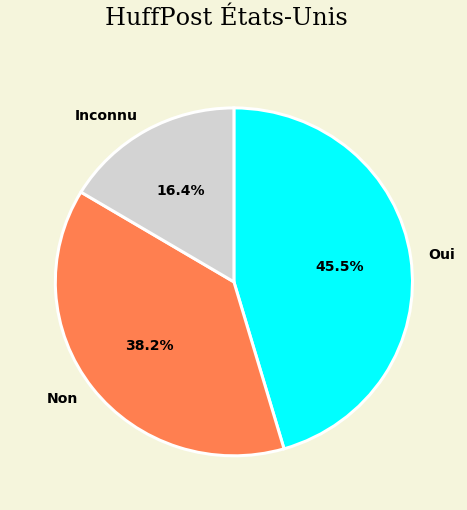

In [18]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost États-Unis", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

In [19]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

video                                     191611
reuters                                   19140 
TV Canada                                 16087 
elections 2012                            11084 
slidepollajax                             10526 
slideexpand                               10288 
Donald Trump                              8057  
2012 election                             7520  
Barack Obama                              7041  
Mitt Romney                               6313  
voices                                    5980  
tv replay                                 5766  
                                          ...   
cool bathroom accessories                 1     
batman arkham                             1     
grammy nomination concert                 1     
Boy and Bear                              1     
men dating                                1     
prince facebook                           1     
house-republicans                         1     
charli xcx i want it